In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

zipcodes = gpd.read_file('zipcode.geojson')
neighs = gpd.read_file('Maryland_Baltimore_City_Neighborhoods.geojson')
mhinc = pd.read_csv('MASTER_MERGED.csv')
covid = pd.read_csv('COVID_Cleaned_Transposed.csv')

sjoined = gpd.sjoin(neighs, zipcodes, how='inner',op='intersects')

sjoined.to_csv('spatialJoin.csv')

In [2]:
sjoined = sjoined[['LABEL','zipcode1']]
sjoined = sjoined.rename(columns={'LABEL':'Neigh','zipcode1':'Zip Code'})
mhinc = mhinc[['Neigh','CSA','MHINC','Pop2010']]

merged = pd.merge_ordered(mhinc, sjoined, fill_method='none')
#print(merged[['CSA','Pop2010']])
merged['Zip Code'] = merged['Zip Code'].astype(int)
merged = merged.sort_values(by=['Zip Code'])
print(merged.head())

            Neigh                                    CSA     MHINC  Pop2010  \
852     Poppleton  Poppleton/The Terraces/Hollins Market   20365.8     5086   
668  Mount Vernon                                Midtown   52477.2    15020   
31   Barre Circle             Washington Village/Pigtown   48273.2     5503   
33   Barre Circle             Washington Village/Pigtown   48273.2     5503   
762     Otterbein              Inner Harbor/Federal Hill  100932.2    12855   

     Zip Code  
852     21201  
668     21201  
31      21201  
33      21201  
762     21201  


In [3]:
incomeMeans = []
popSums = []
zipsList = [21227,21207,21230,21251,21229,21237,21287,21231,21226,21206,21222,21225,21211,21208,\
            21205,21218,21234,21202,21201,21213,21210,21209,21216,21236,21217,21224,21215,21212,\
                21223,21214,21239,21228]

zipsList.sort()

for zipcode in zipsList: 
    df1 = merged[merged['Zip Code'] == zipcode]
    incMean = df1['MHINC'].unique().mean()
    popSum = df1['Pop2010'].unique().sum()
    incomeMeans.append(incMean)
    popSums.append(popSum)

In [4]:
latestCases = pd.DataFrame()

covid = covid.sort_values(by=['Zip Code'])
latestCases['Zip Code'] = covid['Zip Code'].astype(int)
latestCases['MHINC'] = incomeMeans
latestCases['Pop2010'] = popSums
latestCases['TotalCases'] = covid.iloc[:,-1].astype(int)

latestCases.to_csv('Zip_MHINC_Pop.csv')

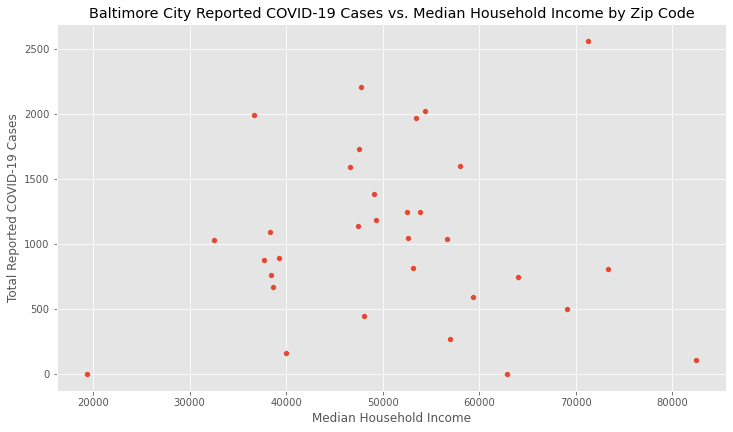

[[1.         0.01662087]
 [0.01662087 1.        ]]


In [5]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='MHINC',y='TotalCases',data=latestCases,legend=False)
_ = plt.xlabel('Median Household Income')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Median Household Income by Zip Code')
plt.show()

corr = np.corrcoef(latestCases[['MHINC','TotalCases']],rowvar=False)
print(corr)

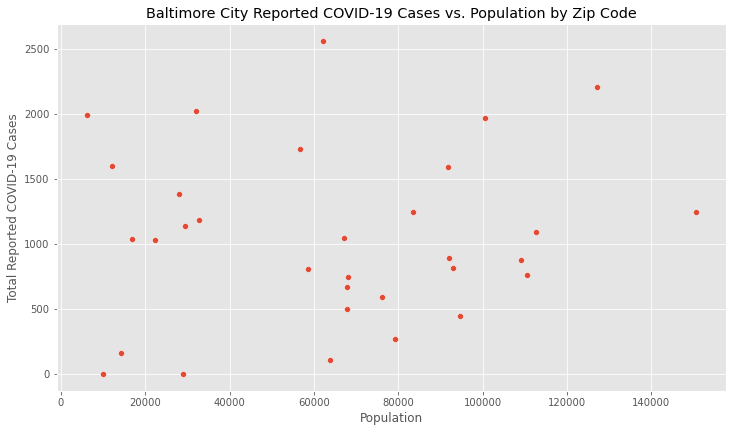

[[1.         0.09147587]
 [0.09147587 1.        ]]


In [6]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='Pop2010',y='TotalCases',data=latestCases,legend=False)
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Population by Zip Code')
plt.show()

corr = np.corrcoef(latestCases[['Pop2010','TotalCases']],rowvar=False)
print(corr)

In [30]:
pops_greater_65k = latestCases[latestCases['Pop2010'] > 65000]

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps

In [48]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(pops_greater_65k['Pop2010'].to_numpy(),pops_greater_65k['TotalCases'].to_numpy(),200)

#95% C.I. for regression line slopes
cis95 = np.percentile(bs_slope_reps,[2.5,97.5])
print(cis95)

[0.00380271 0.02405409]


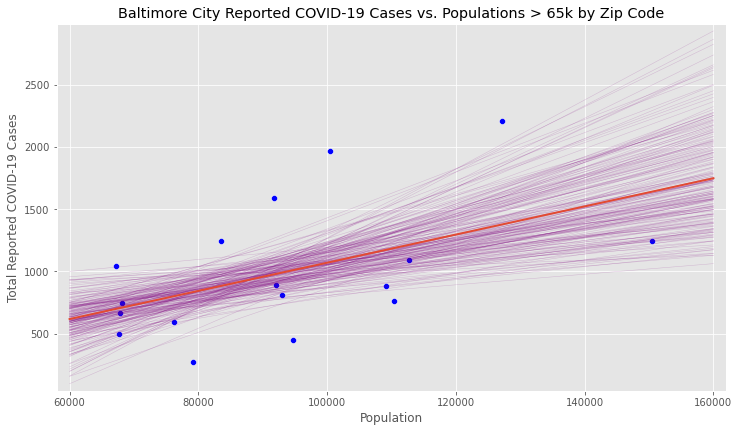

[[1.         0.49941967]
 [0.49941967 1.        ]]


In [49]:
#linear regression with 100 bootstrap lines 
a,b = np.polyfit(pops_greater_65k['Pop2010'],pops_greater_65k['TotalCases'],1)
x = np.array([60000,160000])
y = a * x + b

_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
for i in range(200):
    _ = plt.plot(x,bs_slope_reps[i]*x + bs_intercept_reps[i],
                linewidth=0.5,alpha=0.2,color='purple')
_ = sns.scatterplot(x='Pop2010',y='TotalCases',data=pops_greater_65k,legend=False,color='blue')
_ = plt.plot(x,y,linewidth=2)
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Populations > 65k by Zip Code')
plt.margins(.02)
plt.show()

corr = np.corrcoef(pops_greater_65k[['Pop2010','TotalCases']],rowvar=False)
print(corr)

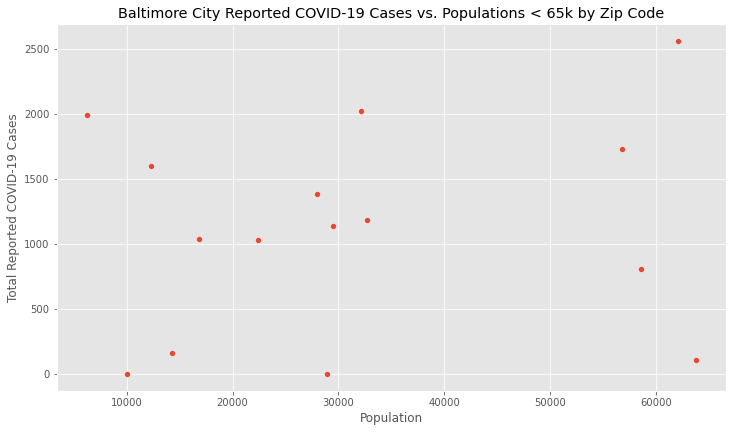

[[1.         0.14761315]
 [0.14761315 1.        ]]


In [39]:
pops_less_65k = latestCases[latestCases['Pop2010'] < 65000]
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='Pop2010',y='TotalCases',data=pops_less_65k,legend=False)
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Populations < 65k by Zip Code')
plt.show()

corr = np.corrcoef(pops_less_65k[['Pop2010','TotalCases']],rowvar=False)
print(corr)

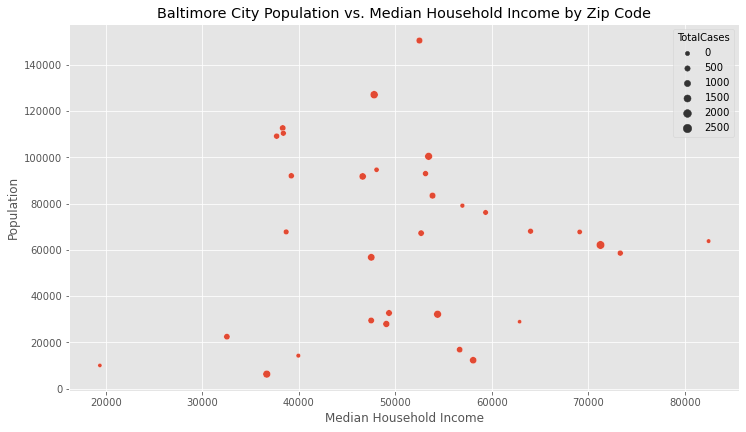

[[1.         0.05581215]
 [0.05581215 1.        ]]


In [11]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='MHINC',y='Pop2010',data=latestCases,size='TotalCases',legend='brief')
_ = plt.xlabel('Median Household Income')
_ = plt.ylabel('Population')
_ = plt.title('Baltimore City Population vs. Median Household Income by Zip Code')
plt.show()

corr = np.corrcoef(latestCases[['Pop2010','MHINC']],rowvar=False)
print(corr)